In this notebook I will be exploring the NBADATA.csv file, and trying to identify the relevant statistics for modelling. This will be split into two sections. 


1. Which stats are the most correlated to victory? 
    By looking at all of these box scores, we can see what the game's final point differential (+/-) was. Using this as an output along with all of the box score statistics, we can infer which values are the most correlated to it, along with other useful takeaways to be described concurrently with the study. 
    

2. How many games are sufficient for lookback? 
    Obviously we cannot use the ingame data for prediction purposes, so some sort of lookback prediction proxy must be used. In order to capture what the teams expected performance will be in the game for prediction, a lookback window will be used over the previous x games to serve as that team's forecasted stats. I will try to identify how many games of lookback is the best for this purpose. 

In [1]:
#import dependencies, and dataset. 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


In [2]:
df = pd.read_csv('30_game_rolling_stats.csv',dtype=np.float32)

In [3]:
outcome = df['PLUS_MINUS'] #df['home_SPREAD'] + df['PLUS_MINUS'] 

In [4]:
y = []
for val in outcome:
    if val>0: 
        y.append(1) #home team wins. 
    else:
        y.append(0)

In [5]:
del df['PLUS_MINUS']

In [6]:
X = df

In [7]:
del X['Unnamed: 0']

In [8]:
sum(y)/len(y)  



0.5903896103896104

# Principal Component Analysis: Can we find a trend?

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(X)

pca = PCA(n_components=2)

In [15]:
pca.fit(X)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  #svd_solver='auto', tol=0.0, whiten=False)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
X_pca = pca.transform(X)

In [37]:
X_embedded.shape

(3850, 2)

In [38]:
len(y)

3850

In [41]:
y = np.array(y)

In [42]:
home_team_wins = X_embedded[y == 1]
home_team_loses = X_embedded[y == 0]

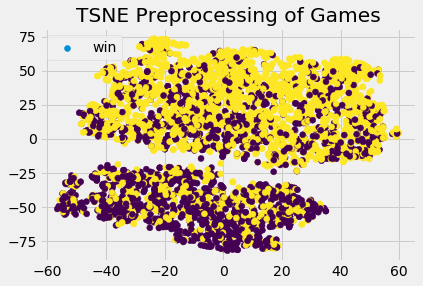

In [36]:
plt.style.use('fivethirtyeight')



home_team_win = X_embedded

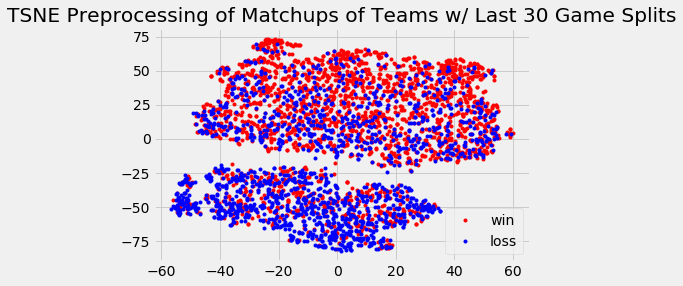

In [55]:
plt.title('TSNE Preprocessing of Matchups of Teams w/ Last 30 Game Splits')
plt.plot(home_team_wins[:,0],home_team_wins[:,1],'r.',label = 'win')

plt.plot(home_team_loses[:,0],home_team_loses[:,1],'b.',label = 'loss')
plt.legend()

The home team roughly wins 60% of the time. 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size = .25)


In [11]:
type(X_test.values[0][0])

numpy.float32

Now prior to normalizing, create a separate var that holds onto all of the spreads for the home teams in the testing games. 

In [12]:
test_spreads = X_test['home_SPREAD']

In [13]:
from sklearn.model_selection import cross_val_score

In [14]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
#X_val = scaler.transform(X_val.values)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

model.fit(X_train,y_train)

#model.score(X_test,y_test)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
cross_val_score(model,X_test,y_test)

array([ 0.66770186,  0.64797508,  0.690625  ])

# Now apply keras model here!

In [ ]:

model=Sequential()
model.add(Dense(50,input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(50,activation='relu'))
#model.add(Dense(8,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=25,epochs=25,validation_split=.2,verbose=1)




In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier()

model.fit(X_train,y_train)

model.score(X_test,y_test)

In [ ]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

# Now apply tensorflow model here!

In [ ]:
import  tensorflow as tf
tf.set_random_seed(456)
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
X_test.shape[0]

In [ ]:
# Generate tensorflow graph
d = X_train.shape[1]
n_hidden = 100
learning_rate = .001
n_epochs = 100
batch_size = 200
dropout_prob = .5

In [ ]:
type(X_train[0][0])

In [ ]:
with tf.name_scope("placeholders"):
    x = tf.placeholder(tf.float32, (None, d))
    y = tf.placeholder(tf.float32, (None,))
    keep_prob = tf.placeholder(tf.float32)
with tf.name_scope("hidden-layer-1"):
    W = tf.Variable(tf.random_normal((d, n_hidden)))
    b = tf.Variable(tf.random_normal((n_hidden,)))
    x_hidden_1 = tf.nn.sigmoid(tf.matmul(x, W) + b)
  # Apply dropout
    x_hidden_1 = tf.nn.dropout(x_hidden_1, keep_prob)

with tf.name_scope("hidden-layer-2"):
    W = tf.Variable(tf.random_normal((n_hidden, n_hidden)))
    b = tf.Variable(tf.random_normal((n_hidden,)))
    x_hidden_2 = tf.nn.sigmoid(tf.matmul(x_hidden_1, W) + b)
  # Apply dropout
    x_hidden_2 = tf.nn.dropout(x_hidden_2, keep_prob)

with tf.name_scope("output"):
    W = tf.Variable(tf.random_normal((n_hidden, 1)))
    b = tf.Variable(tf.random_normal((1,)))
    y_logit = tf.matmul(x_hidden_2, W) + b
  # the sigmoid gives the class probability of 1
    y_one_prob = tf.sigmoid(y_logit)
  # Rounding P(y=1) will give the correct prediction.
    y_pred = tf.round(y_one_prob)
with tf.name_scope("loss"):
  # Compute the cross-entropy term for each datapoint
    y_expand = tf.expand_dims(y, 1)
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_logit, labels=y_expand)
  # Sum all contributions
    l = tf.reduce_sum(entropy)

with tf.name_scope("optim"):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)

with tf.name_scope("summaries"):
    tf.summary.scalar("loss", l)
    merged = tf.summary.merge_all()

In [ ]:
train_writer = tf.summary.FileWriter('/tmp/nba-train',tf.get_default_graph())


In [ ]:
N = X_train.shape[0]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    step = 0
    for epoch in range(n_epochs):
        pos = 0
        while pos < N:
            batch_X = X_train[pos:pos+batch_size]
            batch_y = y_train[pos:pos+batch_size]
            feed_dict = {x: batch_X, y: batch_y, keep_prob: dropout_prob}
            _, summary, loss = sess.run([train_op, merged, l], feed_dict=feed_dict)
            train_writer.add_summary(summary, step)

            step += 1
            pos += batch_size
  # Make Predictions (set keep_prob to 1.0 for predictions)
        train_y_pred = sess.run(y_pred, feed_dict={x: X_train, keep_prob: 1.0})
        val_y_pred = sess.run(y_pred, feed_dict={x: X_val, keep_prob: 1.0})
        print("epoch %d, step %d, loss: %f" % (epoch, step, loss))
        print("training acc. ", accuracy_score(y_train,train_y_pred), "%")
        print("validation acc. ", accuracy_score(y_val,val_y_pred), "%")
    test_y_pred = sess.run(y_pred, feed_dict={x: X_test, keep_prob: 1.0})

train_weighted_score = accuracy_score(y_train, train_y_pred)
print("Train Weighted Classification Accuracy: %f" % train_weighted_score)
#valid_weighted_score = accuracy_score(valid_y, valid_y_pred, sample_weight=valid_w)
#print("Valid Weighted Classification Accuracy: %f" % valid_weighted_score)
test_weighted_score = accuracy_score(y_test, test_y_pred)
print("Test Weighted Classification Accuracy: %f" % test_weighted_score)

In [ ]:
!tensorboard --logdir=/tmp/nba-train 

In [ ]:
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC
model = MLPClassifier()

model.fit(X_train,y_train)



In [ ]:
model.score(X_train,y_train)

In [ ]:
model.score(X_test,y_test)

Now to compare: 

In [ ]:
predictions = model.predict(X_test)


for i,prediction in enumerate(predictions):
   # print("Prediction: ", prediction)
    #print("Spread of the home team for this game: ", test_spreads.values[i])
    
    if test_spreads.values[i] > 0 and prediction ==1:
        print("Picked a home team underdog")
        
    if test_spreads.values[i] < 0 and prediction ==0:
        print("Picked a away team underdog")

This is a good time to note this seems to very rarely pick underdogs, but more often it does on the road.  -- OK now the model picks the opposite, let's come back to this later after a proper payout calculator is made at least. 

In [ ]:
def spread2ML(spread):
    """Converts spread into a moneyline value using the equation I derived in another notebook. 
    """
    if spread <=1.5:
        
        ML = 1.71409498 * spread**3 + 10.90008433 * spread **2 + 22.40247106 * spread - 138.20112341
    else: 

        ML = 1.66494668 * spread**3 -20.03302374 * spread**2 + 101.20347437 * spread - 34.68833849
    
    return ML


def ML2Payout(ML,bet,win=True):
    """Convert Moneyline odds to a payout. 
    """
    if win:
        if ML < 0: # - moneyline, 
        # PAYOUT = BET AMOUNT / (-1 *MONEYLINE ODDS / 100)

            payout = bet / (-1*ML/100)

        elif ML > 0:   #now for the underdog
        #PAYOUT = BET AMOUNT * ODDS / 100
            payout = (bet * ML) / 100

            
        else:
            payout = bet
    else:
        if ML > 0: 
            payout = -bet
        elif ML < 0:
            #in the circumstances where its a favorite, the computer makes you put down more. ie -190 means 19 to win 10. 
            payout = -bet
            
        else:
            payout = -bet
    
    return payout 

In [ ]:
spread2ML(1)

In [ ]:
def risk2payout(ML,bet,win=True):
    """Depending on the moneyline, the risk reward formula changes. 
    """
    
    if ML < 0: # if betting on a favorite. 
        
        risk = -ML/bet
        reward = bet
        if win:
            payout = reward
        else:
            payout = -risk
        
    if ML > 0: #if betting on an underdog. 
        risk = bet
        reward = ML/bet
        
        if win:
            payout = reward #this is your risked money back, plus the reward. 
        else:
            payout = -risk  #this is how much you risked, and it's gone. 
    
    return risk, payout
        
        
        
        
        

In [ ]:
risk2payout(-105,10,win=False)

In [ ]:
money_made = 0
acc_count = 0
total_winings = 0
total_losings = 0
init_bet = 10

for i,prediction in enumerate(predictions):
       
     
    
    spread = test_spreads.values[i]
    ML_odds = spread2ML(spread)
    print()
    print("Odds of Game: ", ML_odds)

   # ML * 
    print("Spread of Game: ",spread)

    if y_test[i] == prediction:
        acc_count+=1
        risk , winnings = risk2payout(ML_odds,init_bet,win=True)
        print("Correct! Win $", winnings)
        print("You risked $",risk)
       # print('$',winnings)
        
        money_made += winnings
        total_winings += winnings
       # if ML_odds < -
    else:
        _ , losings = risk2payout(ML_odds,init_bet,win=False)
        print("Wrong! Lose $", -losings)

        money_made += losings
        total_losings += losings
     #   print("xxx")
    
    
  #  if test_spreads.values[i] > 0 and prediction ==1:
   #     print("Picked a home team underdog")
  #      
  #  if test_spreads.values[i] < 0 and prediction ==0:
   #     print("Picked a away team underdog")

In [ ]:
money_made

In [ ]:
total_winings

In [ ]:
total_losings

# So considering the spread along with these rolling statistics, able to successfully pick the winner of NBA games with approximately 69% accuracy. By also considering moneyline odds converted from spread, how much money do you win? 

In [ ]:
len(X_test)

# Quick Review

# 1. Identified stats most correlated to point differential in a game.

# 2. Identified ngamesplits most correlated to performance in said game. 

# 3. Trained a model on these statistics and found can pick winners with ~68% accuracy, and spread still barely over 50%. 

# What's up for next time? Refactor this code, and turn into an updateable model as more games come in using those scrapers, and also provide a fast application for guess and check. Also convert between traditional spread to create a converter for money made. 